In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV
import os
import ast

from pathlib import Path
import pickle

from surrogates.system import SystemSurrogate
from utils import ax_default

In [2]:
# Load the full SystemSurrogate
save_dir = 'mf_2023-11-02T17.57.44/multi-fidelity'
base_dir = Path('../../results/surrogates')
root_dir = base_dir / save_dir
surr = SystemSurrogate.load_from_file(root_dir / 'sys' / 'sys_final.pkl', root_dir=root_dir)
surr.set_output_dir({'Thruster': None})  # Don't save outputs for testing
sys_qoi = [1, 2, 8, 9]
thruster_qoi = [i-1 for i in sys_qoi]

[juliapkg] Locating Julia ^1.9
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] Using Julia 1.9.3 at C:\Users\eckel\anaconda3\envs\hall_pem\julia_env\pyjuliapkg\install\bin\julia.exe
[juliapkg] Using Julia project at C:\Users\eckel\anaconda3\envs\hall_pem\julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.add([Pkg.PackageSpec(name="HallThruster", uuid="2311f341-5e6d-4941-9e3e-3ce0ae0d9ed6", url=raw"https://github.com/UM-PEPL/HallThruster.jl"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
2023-11-03 16:18:29,605 — [INFO] — surrogates.system.SystemSurrogate    — SystemSurrogate loaded from C:\Users\eckel\Documents\GitHub\HallThrusterPEM\results\surrogates\mf_2023-11-02T17.57.44\multi-fidelity\sys\sys_final.pkl


In [3]:
# Load training set
thruster = surr['Thruster']
xdim, ydim = len(thruster.x_vars), thruster.ydim
xi, yi = thruster.get_training_data()
xtrain, ytrain = np.empty((0, xdim)), np.empty((0, ydim))

# Combine data from multiple model fidelities
for alpha, x in xi.items():
    for i in range(x.shape[0]):
        # Keep highest-fidelity training samples for duplicate x
        diff = np.abs(xtrain - x[i, :])
        idx = np.count_nonzero(diff, axis=-1) == 0  
        if np.any(idx):
            # print(f'{alpha}: i={i}, x={x[i, :]}')
            ytrain[idx, :] = yi[alpha][i, :]  # Should at most only have one True
        else:
            xtrain = np.concatenate((xtrain, x[np.newaxis, i, :]), axis=0)
            ytrain = np.concatenate((ytrain, yi[alpha][np.newaxis, i, :]), axis=0)
ytrain = ytrain[:, thruster_qoi]
xtrain.shape, ytrain.shape

((1815, 12), (1815, 4))

In [4]:
# Make sure there are no duplicate x's remaining in the training set
diff = np.abs(np.expand_dims(xtrain, axis=0) - np.expand_dims(xtrain, axis=1))
idx = np.count_nonzero(diff, axis=-1) == 0
idx = np.count_nonzero(idx, axis=-1)  # Should be identity matrix of length Nx (each point is only equal to itself)
np.any(idx > 1) 

False

In [5]:
# Load system test set
# with open(Path('../../models/data') / 'test_set.pkl', 'rb') as fd:
#     data = pickle.load(fd)
#     xtest_sys, ytest_sys = data['xt'], data['yt']
xtest_sys, ytest_sys = surr.build_metrics['xt'], surr.build_metrics['yt']
xtest_sys.shape, ytest_sys.shape

((994, 22), (994, 27))

In [6]:
# Get system surrogate prediction
yt_surr = surr(xtest_sys)
yt_surr = yt_surr[:, sys_qoi]   # (Nt, Nq)
yt_surr.shape

(994, 4)

In [7]:
# Convert test set to thruster inputs/outputs
exo_in = surr.graph.nodes['Thruster']['exo_in']
global_in = surr.graph.nodes['Thruster']['global_in']
xtest = np.concatenate((xtest_sys[:, exo_in], ytest_sys[:, global_in]), axis=-1)    # (Nt, 12)
ytest = ytest_sys[:, sys_qoi]                                                       # (Nt, Nq)
xtest.shape, ytest.shape

((994, 12), (994, 4))

Training set R2 values: [0.2373572  0.87227649 0.93743001 0.93934878]. Uniform average: 0.7466031192759521
Relative L2 error on test set: [0.16782767 0.33457866 1.25823059 1.02193724]
Relative L2 error on training set: [0.31959844 0.16392638 0.23832824 0.24491348]


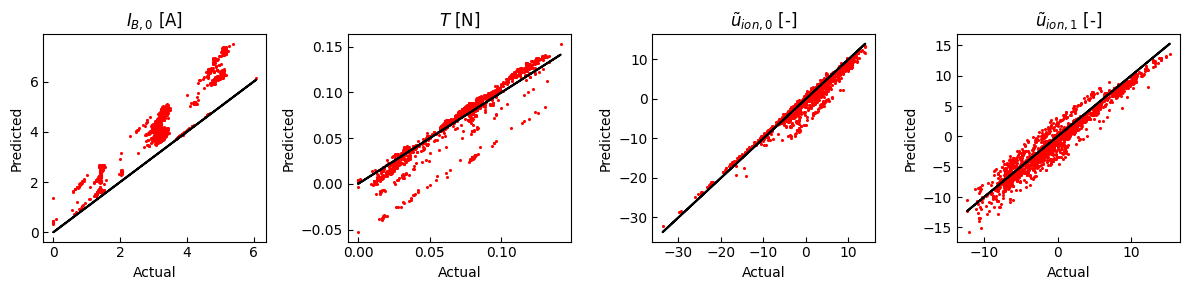

In [8]:
# Test MISC surrogate on training set
model = surr.get_component('Thruster')
ytrain_ridge = model(xtrain)[:, thruster_qoi]
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_surr)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
labels = [surr.coupling_vars[i].to_tex(units=True) for i in sys_qoi]
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Training set R2 values: [ 0.93896277  0.59538279 -1.3391521  -0.0324762 ]. Uniform average: 0.040679315045458186
Relative L2 error on test set: [0.2823856  0.22818453 0.95691383 1.1220737 ]
Relative L2 error on training set: [0.0683689  0.20362787 0.8251042  0.71149179]


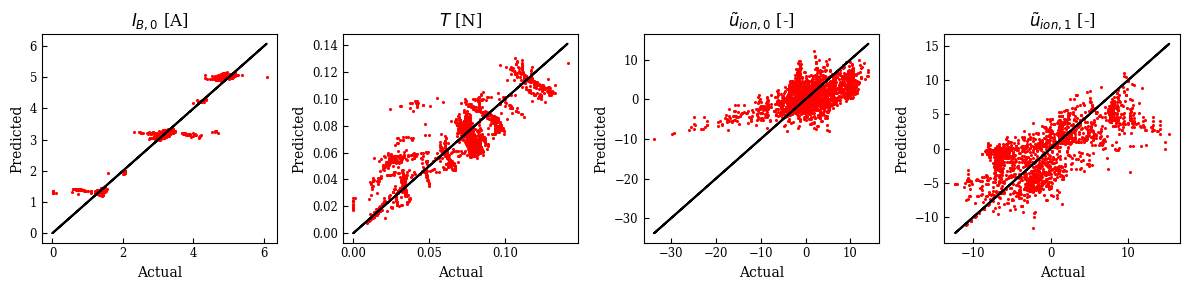

In [9]:
# Test scikit-learn regression
model = Ridge(alpha=0.1)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END features__degree=2, scaler=StandardScaler();, score=0.731 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=StandardScaler();, score=0.762 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=StandardScaler();, score=0.806 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=StandardScaler();, score=0.677 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=StandardScaler();, score=0.749 total time=   0.0s
[CV 1/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.691 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.747 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.777 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.697 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.764 total time=   0.0s
[CV 1/5] END features__degree=3, scaler=StandardSc

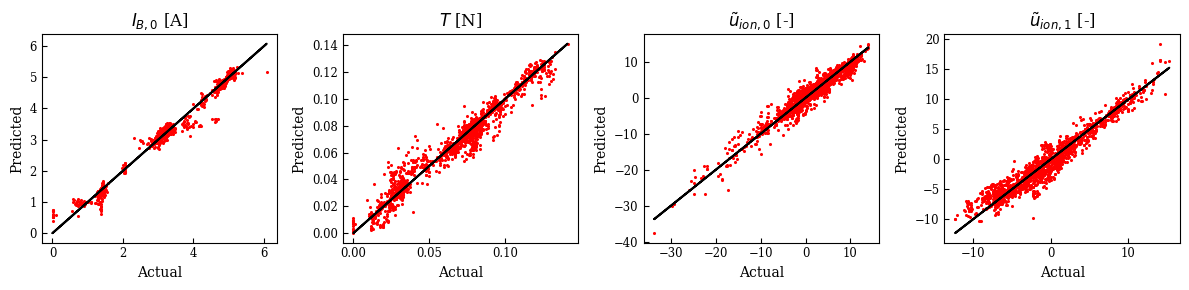

In [10]:
# Test scikit-learn regression
pipe = Pipeline([('scaler', StandardScaler()),
                  ('features', PolynomialFeatures()),
                  ('model', Ridge(alpha=1))])
params = {'features__degree': [2, 3, 4],
          'scaler': [StandardScaler(), MaxAbsScaler()]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-7.463 total time=   0.2s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-4.015 total time=   0.2s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-3.539 total time=   0.2s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-15.085 total time=   0.2s
[CV 5/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-2.434 total time=   0.2s
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-3.018 total time=   0.1s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-2.237 total time=   0.1s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-1.975 total time=   0.1s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-12.566 total time=   0.1s
[CV 5/5] END model__alpha=0.01, model__kernel__leng

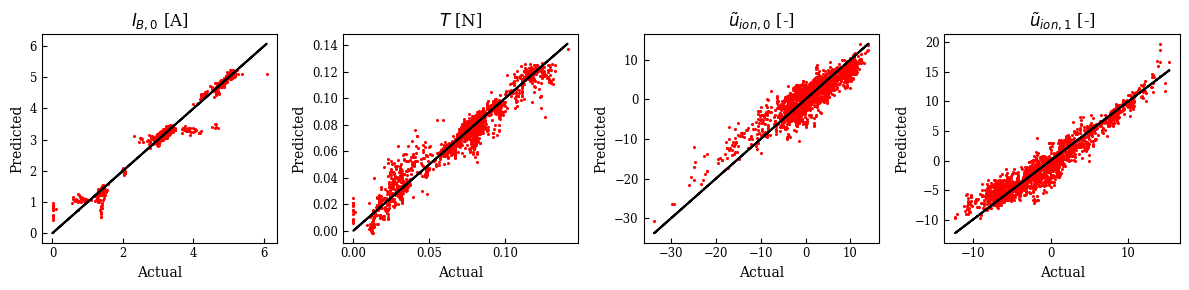

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', GaussianProcessRegressor(n_restarts_optimizer=0, kernel=RBF(length_scale_bounds='fixed')))])
params = {'model__alpha': [1e-2, 1e-1],
          'model__kernel__length_scale': [0.01, 0.1, 1, 10]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Iteration 1, loss = 9.65135547
Iteration 2, loss = 8.86660832
Iteration 3, loss = 8.64499171
Iteration 4, loss = 8.46970464
Iteration 5, loss = 8.31167590
Iteration 6, loss = 8.14945241
Iteration 7, loss = 7.98565068
Iteration 8, loss = 7.78281730
Iteration 9, loss = 7.57507800
Iteration 10, loss = 7.35213304
Iteration 11, loss = 7.12873840
Iteration 12, loss = 6.92430063
Iteration 13, loss = 6.70114417
Iteration 14, loss = 6.47567475
Iteration 15, loss = 6.24663091
Iteration 16, loss = 6.04029757
Iteration 17, loss = 5.82853962
Iteration 18, loss = 5.63779949
Iteration 19, loss = 5.46322369
Iteration 20, loss = 5.30752783
Iteration 21, loss = 5.16458983
Iteration 22, loss = 5.03363827
Iteration 23, loss = 4.91046800
Iteration 24, loss = 4.80064664
Iteration 25, loss = 4.70868708
Iteration 26, loss = 4.62170076
Iteration 27, loss = 4.53406363
Iteration 28, loss = 4.47292535
Iteration 29, loss = 4.39184252
Iteration 30, loss = 4.35325590
Iteration 31, loss = 4.27157834
Iteration 32, los

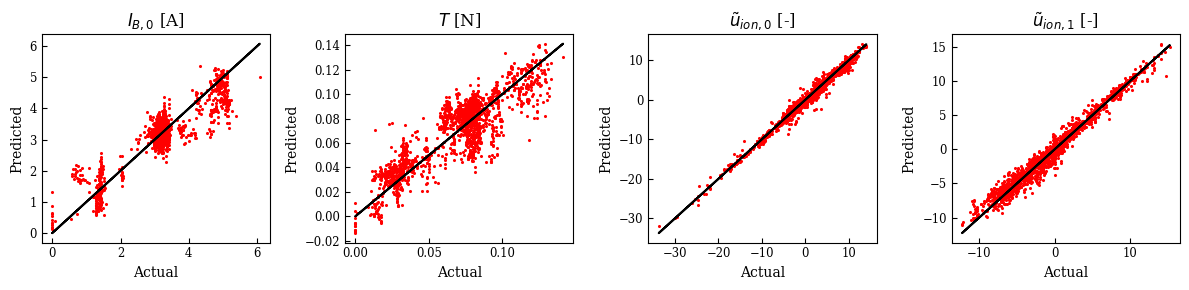

In [12]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 10), alpha=1e-2, learning_rate_init=0.001, max_iter=4000, verbose=True, tol=1e-12, batch_size=64, n_iter_no_change=50, validation_fraction=0.1))])
# params = {'model__hidden_layer_sizes': [(20, 10), (20, 10, 5), (50, 30, 10), (10, 5)],
#           'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
#           'model__learning_rate_init': [1e-3, 1e-2, 1e-1]
#           }
# model = GridSearchCV(pipe, params, cv=10, verbose=3)
model = pipe
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')
rel_error = np.sqrt(np.mean((ytrain - ytrain_ridge)**2, axis=0)) / np.sqrt(np.mean(ytrain**2, axis=0))     # (Nq,)
print(f'Relative L2 error on training set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

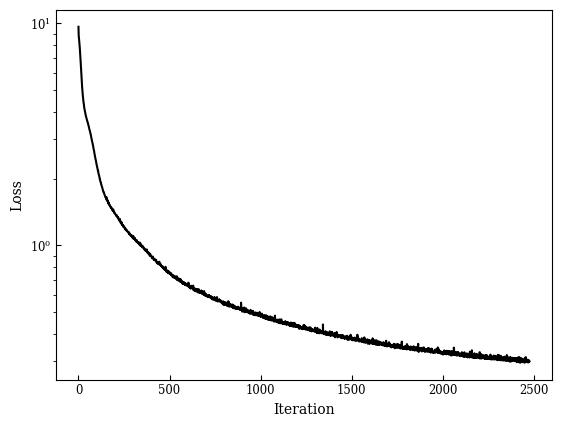

In [13]:
l = model['model'].loss_curve_
fig, ax = plt.subplots()
ax.plot(l, '-k')
ax.set_yscale('log')
ax_default(ax, 'Iteration', 'Loss', legend=False)
plt.show()

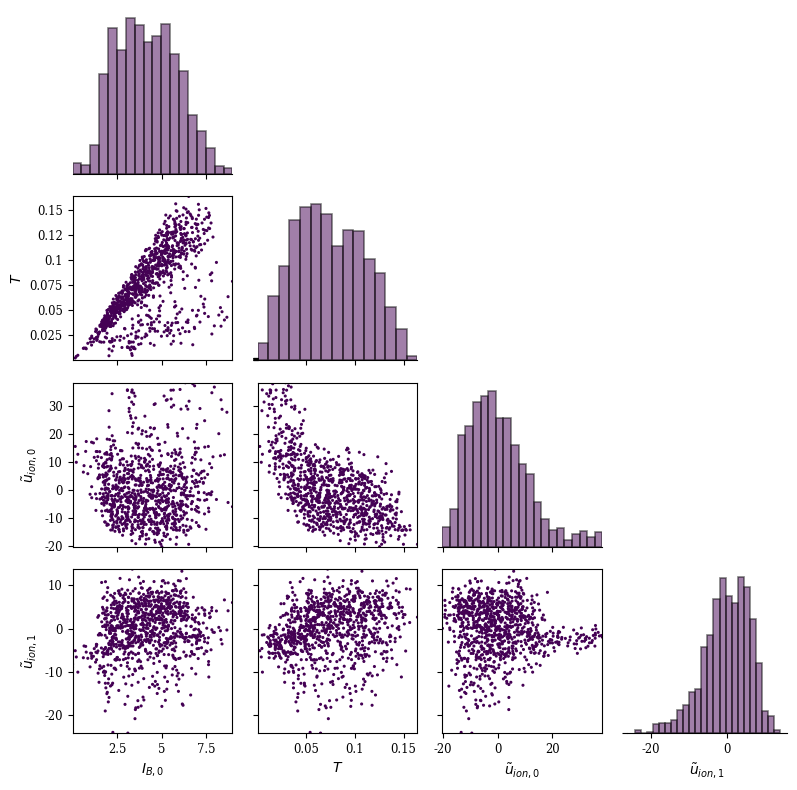

In [14]:
# Scatter plots of input/output spaces
from uq.mcmc import ndscatter

# labels = [var.to_tex() for var in surr['Thruster'].x_vars]
labels = [var.to_tex() for i, var in enumerate(surr.coupling_vars) if i in sys_qoi]
fig, ax = ndscatter(ytest, labels=labels, subplot_size=2)
plt.show()

In [96]:
# Find what is causing negative thrust and NaN cases
import os
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../surrogates') / save_dir / 'components' / 'Thruster'
x = np.zeros((0, 14))
y = np.zeros((0, 26))
for f in os.listdir(root_dir):
    if f.endswith('.pkl'):
        with open(root_dir / f, 'rb') as fd:
            data = pickle.load(fd)
            x = np.concatenate((x, data['x']), axis=0)
            y = np.concatenate((y, data['y']), axis=0)
x.shape, y.shape

((6476, 14), (6476, 26))

In [108]:
nan_idx = np.where(np.any(np.isnan(y), axis=-1))[0]
neg_idx = np.where(y[:, 1] < 0)[0]
nan_idx.shape, neg_idx.shape

((77,), (121,))

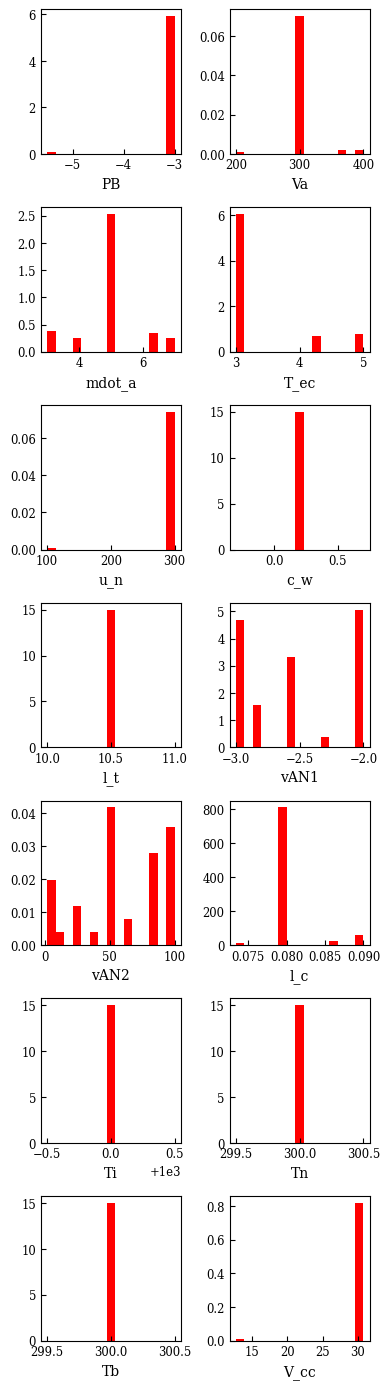

In [135]:
fig, axs = plt.subplots(7, 2)
curr_idx = 0
thruster_idx = [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = [str(var) for i, var in enumerate(surr.exo_vars) if i in thruster_idx] + ['V_cc']
for i in range(7):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(x[nan_idx, curr_idx], color='red', linewidth=1.2, density=True, bins=15)
        ax_default(ax, labels[curr_idx], '', legend=False)
        curr_idx += 1
fig.set_size_inches(4, 14)
fig.tight_layout()
plt.show()